In [83]:
import sys
sys.path.append('../../Common/')

import CommonMT5, CommonBacktest

In [84]:
# Định nghĩa hàm tín hiệu mua
def buy_signal(row):
    if row['Close'] > row['candle_avg'] and row['macd_histogram'] > row['macd_histogram_shifted']:
        return True
    else:
        return False

# Định nghĩa hàm tín hiệu bán
def sell_signal(row):
    if row['Close'] < row['candle_avg'] and row['macd_histogram'] < row['macd_histogram_shifted']:
        return True
    else:
        return False

def detectSignal(symbol, from_date, to_date, timeframe):

    import pandas as pd
    import plotly.graph_objects as go
    import redis
    import numpy as np
    import ta
    from datetime import datetime

    # ##############################################Step 1: Lấy dữ liệu##############################################
    data = CommonMT5.CommonMT5.loaddataMT5_FromTo(symbol, from_date, to_date, timeframe)
    
    # ##############################################Step 2: Chiến lược##############################################  
    # Tính toán các chỉ báo kỹ thuật
    
    # Tính toán các đường EMA (Exponential Moving Average) cho MACD
    ema_short = data['Close'].ewm(span=12, adjust=False).mean()  # Thường là EMA 12 ngày
    ema_long = data['Close'].ewm(span=26, adjust=False).mean()   # Thường là EMA 26 ngày

    # Tính toán đường MACD và đường Signal
    macd = ema_short - ema_long
    signal = macd.ewm(span=9, adjust=False).mean()  # Thường là EMA 9 ngày của đường MACD

    # Tính toán histogram MACD (chênh lệch giữa MACD và đường Signal)
    data['macd_histogram'] = macd - signal

    # Tạo cột 'candle_avg' dựa trên điều kiện đã định nghĩa
    data['candle_avg'] = data['Close'].rolling(window=2).mean()

    # Tạo một cột 'macd_histogram_shifted' bằng cách dịch chuyển 'macd_histogram' xuống một hàng
    data['macd_histogram_shifted'] = data['macd_histogram'].shift(1)

    # Áp dụng hàm tín hiệu mua và bán
    data['Buy_Signal'] = data.apply(lambda row: buy_signal(row), axis=1)
    data['Sell_Signal'] = data.apply(lambda row: sell_signal(row), axis=1)

    return data

In [85]:
import MetaTrader5 as mt5
from datetime import datetime, timedelta
import ta
import schedule
import time

symbol = 'EURUSD'
from_date = (datetime.now() - timedelta(days=50)).strftime('%Y-%m-%d')
to_date = (datetime.now() + timedelta(days=1)).strftime('%Y-%m-%d')
timeframe = mt5.TIMEFRAME_D1
data = detectSignal(symbol, from_date, to_date, timeframe)

In [86]:
data

,Datetime,Open,High,Low,Close,Volume,macd_histogram,candle_avg,macd_histogram_shifted,Buy_Signal,Sell_Signal
0,2024-01-03,1.09423,1.09654,1.08929,1.09196,83442,0.000000,NaN,NaN,False,False
1,2024-01-04,1.09191,1.09721,1.09140,1.09478,74384,0.000180,1.093370,0.000000,True,False
2,2024-01-05,1.09465,1.09984,1.08765,1.09409,89593,0.000239,1.094435,0.000180,False,False
3,2024-01-08,1.09422,1.09789,1.09224,1.09508,67255,0.000326,1.094585,0.000239,True,False
4,2024-01-09,1.09520,1.09662,1.09103,1.09310,71137,0.000235,1.094090,0.000326,False,True
5,2024-01-10,1.09276,1.09728,1.09227,1.09720,64649,0.000425,1.095150,0.000235,True,False
6,2024-01-11,1.09692,1.09985,1.09302,1.09727,92481,0.000523,1.097235,0.000425,True,False
7,2024-01-12,1.09724,1.09869,1.09359,1.09496,79300,0.000405,1.096115,0.000523,False,True
8,2024-01-15,1.09463,1.09675,1.09334,1.09504,48832,0.000310,1.095000,0.000405,False,False
9,2024-01-16,1.09476,1.09508,1.08619,1.08756,91630,-0.000249,1.091300,0.000310,False,True


# Backtest

g:\My Drive\0. Day ben ngoai (___)\Day Cole\Khoa ML for invesment - Thanhdt (11.2023)\Chien luoc hoc vien\Mr Long\../../Common\CommonBacktest.py:270: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '49726.4775' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



Ngày vào lệnh đầu tiên: 2
Tổng lợi nhuận: -8130.5574999999735
Tổng giá trị tài khoản cuối cùng: 41869.44250000003
Lợi nhuận thị trường: -0.98721564892487%
Lợi nhuận chiến lược: -16.261114999999947%


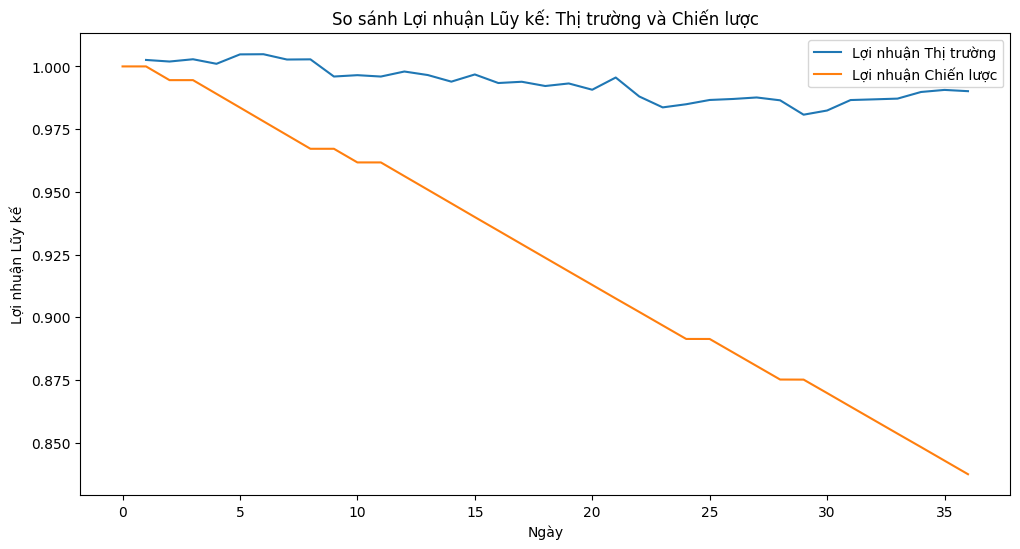

In [87]:
dataAfterBT = CommonBacktest.CommonBacktest.backtestForex(data, 50000, 0.5, 200, 100, 50)

In [88]:
dataAfterBT

,Datetime,Open,High,Low,Close,Volume,macd_histogram,candle_avg,macd_histogram_shifted,Buy_Signal,Sell_Signal,Position_Buy,Position_Sell,Trade_Action,Capital,Market_Return,Cumulative_Market_Returns,Strategy_Value,Cumulative_Strategy_Returns
0,2024-01-03,1.09423,1.09654,1.08929,1.09196,83442,0.000000,NaN,NaN,False,False,NaN,NaN,,50000.0000,NaN,NaN,50000.0000,1.000000
1,2024-01-04,1.09191,1.09721,1.09140,1.09478,74384,0.000180,1.093370,0.000000,True,False,False,False,,50000.0000,0.002583,1.002583,50000.0000,1.000000
2,2024-01-05,1.09465,1.09984,1.08765,1.09409,89593,0.000239,1.094435,0.000180,False,False,True,False,Buy,49726.4775,-0.000630,1.001951,49726.4775,0.994530
3,2024-01-08,1.09422,1.09789,1.09224,1.09508,67255,0.000326,1.094585,0.000239,True,False,False,False,,49726.4775,0.000905,1.002857,49726.4775,0.994530
4,2024-01-09,1.09520,1.09662,1.09103,1.09310,71137,0.000235,1.094090,0.000326,False,True,True,False,"Buy, Stop Loss Long",49452.9550,-0.001808,1.001044,49452.9550,0.989059
5,2024-01-10,1.09276,1.09728,1.09227,1.09720,64649,0.000425,1.095150,0.000235,True,False,False,True,"Sell, Take Profit Long",49179.6800,0.003751,1.004799,49179.6800,0.983594
6,2024-01-11,1.09692,1.09985,1.09302,1.09727,92481,0.000523,1.097235,0.000425,True,False,True,False,Buy,48905.3625,0.000064,1.004863,48905.3625,0.978107
7,2024-01-12,1.09724,1.09869,1.09359,1.09496,79300,0.000405,1.096115,0.000523,False,True,True,False,"Buy, Take Profit Short, Stop Loss Long",48631.6050,-0.002105,1.002747,48631.6050,0.972632
8,2024-01-15,1.09463,1.09675,1.09334,1.09504,48832,0.000310,1.095000,0.000405,False,False,False,True,Sell,48357.8450,0.000073,1.002821,48357.8450,0.967157
9,2024-01-16,1.09476,1.09508,1.08619,1.08756,91630,-0.000249,1.091300,0.000310,False,True,False,False,", Stop Loss Long, Take Profit Short",48357.8650,-0.006831,0.995971,48357.8650,0.967157
